# Music generation

## import packages

In [23]:
import tensorflow
import numpy as np
import os
import pandas as pd
from collections import Counter
from hmmtool import HMM
import numpy as np
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## load data

使用古典钢琴音乐的MIDI文件。

In [24]:
# pianist = "Debussy"
# pianist = "Chopin"
pianist = "Bach"

In [25]:
filepath = "dataset/piano/bach/bach1/"
#Getting midi files
all_midis = []
for i in os.listdir(filepath):
    if i.endswith(".mid") or i.endswith(".MID"):
        tr = filepath + i
        midi = converter.parse(tr)
        all_midis.append(midi)
all_midis

[<music21.stream.Score 0x161304580>]

In [26]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

debussy = extract_notes(all_midis)
print("Total notes in all the {0} midis in the dataset:".format(pianist), len(debussy))

Total notes in all the Bach midis in the dataset: 1263


In [27]:
print("First fifty values in the {0}:".format(pianist), debussy[:50])
print(len(debussy))

First fifty values in the Bach: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']
1263


In [28]:
# def show(music):
# display(Image(str(music.write("lily.png"))))
def chords_n_notes(Snippet):
    Melody = []
    offset = 0  #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")  #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi


Melody_Snippet = chords_n_notes(debussy[:100])
# show(Melody_Snippet)

In [29]:
#to play audio or corpus
print("Sample Audio From Data")
# IPython.display.Audio()

Sample Audio From Data


In [30]:
#Creating a count dictionary
debussy_num = Counter(debussy)
print("Total unique notes in the {0}:".format(pianist), len(debussy_num))

Total unique notes in the Bach: 54


In [31]:
Notes = list(debussy_num.keys())
Recurrence = list(debussy_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)


print("Average recurrenc for a note in {0}:".format(pianist), Average(Recurrence))
print("Most frequent note in {0} appeared:".format(pianist), max(Recurrence), "times")
print("Least frequent note in {0} appeared:".format(pianist), min(Recurrence), "time")

Average recurrenc for a note in Bach: 23.38888888888889
Most frequent note in Bach appeared: 104 times
Least frequent note in Bach appeared: 1 time


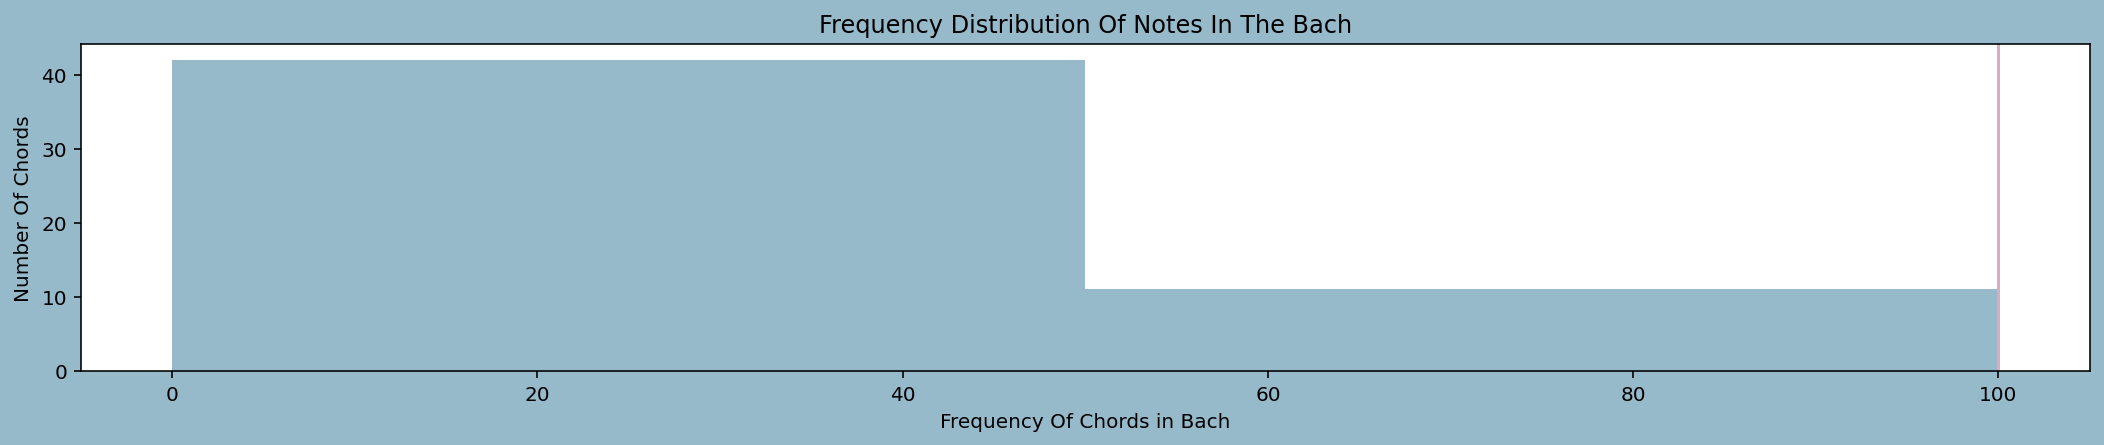

In [32]:
# Plotting the distribution of Notes
plt.figure(figsize=(18, 3), facecolor="#97BACB")
bins = np.arange(0, (max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100, color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The {0}".format(pianist))
plt.xlabel("Frequency Of Chords in {0}".format(pianist))
plt.ylabel("Number Of Chords")
plt.show()

In [33]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(debussy_num.items()):
    if value < 100:
        m = key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 53


In [34]:
#Eleminating the rare notes
for element in debussy:
    if element in rare_note:
        debussy.remove(element)
print("Length of {0} after elemination the rare notes:".format(pianist), len(debussy))

Length of Bach after elemination the rare notes: 666


## Data processing


In [35]:
symb = sorted(list(set(debussy)))

L_corpus = len(debussy)  #length of corpus
L_symb = len(symb)  #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))
print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)


Total number of characters: 666
Number of unique characters: 45


In [71]:
length = 100
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = debussy[i:i + length]
    target = debussy[i + length]
    # features.append(feature)
    # targets.append(target)
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Total number of sequences in the {0}:".format(pianist), L_datapoints)

Total number of sequences in the Bach: 566


In [37]:
# reshape X and normalize
# X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
# X = (np.reshape(features, (L_datapoints, length)))/ float(L_symb)
# one hot encode the output variable
# y = tensorflow.keras.utils.to_categorical(targets)

In [38]:
#Taking out a subset of data to be used as seed
# X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_seed, y_train, y_seed = train_test_split(X, np.array(targets), test_size=0.2, random_state=42)

In [72]:
data = pd.DataFrame(debussy, columns=["chords"])
n = length
print(n)
chords = data['chords'].values
ngrams = zip(*[chords[i:] for i in range(n)])
bigrams = [" ".join(ngram) for ngram in ngrams]
print(len(bigrams))
# print(bigrams[:50])

100
567


## Test: try to predict next state with Markov chain

In [84]:
def predict_next_state(chord:str, data:list=bigrams):
    """Predict next chord based on current state."""
    # create list of bigrams which stats with current chord
    bigrams_with_current_chord = [bigram for bigram in bigrams if bigram.split(' ')[0]==chord]
    print(bigrams_with_current_chord)
    # count appearance of each bigram
    count_appearance = dict(Counter(bigrams_with_current_chord))
    # convert apperance into probabilities
    for ngram in count_appearance.keys():
        count_appearance[ngram] = count_appearance[ngram]/len(bigrams_with_current_chord)
    # create list of possible options for the next chord
    options = [key.split(' ')[1] for key in count_appearance.keys()]
    # create  list of probability distribution
    probabilities = list(count_appearance.values())
    print(probabilities)
    # return np.random.choice(options, p=probabilities)
    if options:
        print("yes")
        return np.random.choice(options, p=probabilities)
    else:
        print("no")
        return np.random.choice(bigrams)

In [60]:
def generate_sequence(chord:str=None, data:list=bigrams, length:int=40):
    """Generate sequence of defined length."""
    # create list to store future chords
    chords = []
    for n in range(length):
        # append next chord for the list
        chords.append(predict_next_state(chord, bigrams))
        # use last chord in sequence to predict next chord
        chord = chords[-1]
    return chords

## Generate music

In [88]:
# example
seed = bigrams[np.random.randint(0, len(bigrams)-1)]
print(type(seed))
print(seed)

<class 'str'>
F#4 G4 E4 G3 D4 A4 E4 C4 G3 D4 B4 C4 A3 B3 G3 C5 D4 A3 F#3 G3 A3 D3 0.2 F#3 B4 G3 G3 A4 E5 G4 B3 F4 A4 E4 C4 G4 D5 F4 D4 A4 D5 G4 E4 G3 E5 D5 C5 4.5 B4 D4 C5 A4 D5 G4 E5 F5 C5 C4 A3 G5 A5 F4 G5 F5 D5 B3 E5 G4 D5 G4 F4 C4 C5 E4 B4 G4 D4 F3 A3 G3 F3 C5 E4 E3 D3 D5 F4 D4 C3 B2 G4 C3 D3 C5 E4 G3 E3 F3 D4 G3


In [92]:
pred = predict_next_state("G3")
# Music = pred.split(" ")

['G3 C4 G2 G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 B3 G3 B3 G2 G3 B3 G3 B3 C2 G3 B-3 G3 B-3 C2 G3 B-3 G3 B-3 0 C4 C4 C4 0 C4 E4 E4 E4 C4 C4 B3 E4 G3 E4 A3 B3 C4 C4 B3 G4 E4 C5 G4 A3 E4 C5 E4 C4 G4 B3 E4 C4 G4 D4 E4 F4 B-3 G4 C4 A3 G4 F4 D4 C5 G3 G4 F4 C4 A3 E4 F4 A3 D4 B3 G3 C4 G4 D4 A3 G3 G4 G3', 'G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 B3 G3 B3 G2 G3 B3 G3 B3 C2 G3 B-3 G3 B-3 C2 G3 B-3 G3 B-3 0 C4 C4 C4 0 C4 E4 E4 E4 C4 C4 B3 E4 G3 E4 A3 B3 C4 C4 B3 G4 E4 C5 G4 A3 E4 C5 E4 C4 G4 B3 E4 C4 G4 D4 E4 F4 B-3 G4 C4 A3 G4 F4 D4 C5 G3 G4 F4 C4 A3 E4 F4 A3 D4 B3 G3 C4 G4 D4 A3 G3 G4 G3 F3 C5 D5', 'G3 C4 G2 G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 B3 G3 B3 G2 G3 B3 G3 B3 C2 G3 B-3 G3 B-3 C2 G3 B-3 G3 B-3 0 C4 C4 C4 0 C4 E4 E4 E4 C4 C4 B3 E4 G3 E4 A3 B3 C4 C4 B3 G4 E4 C5 G4 A3 E4 C5 E4 C4 G4 B3 E4 C4 G4 D4 E4 F4 B-3 G4 C4 A3 G4 F4 D4 C5 G3 G4 F4 C4 A3 E4 F4 A3 D4 B3 G3 C4 G4 D4 A3 G3 G4 G3 F3 C5 D5 G3 A3', 'G3 C4 G3 C4 G2 G3 C4 G3 C4 G2 G3 B3 G3 B3 G2 G3 B3 G3 B3 C2 G3 B-3 G3 B-3 C2 G3 

In [51]:
# Melody = chords_n_notes(Music)
# Melody_midi = stream.Stream(Melody)
# filename = "seed_music_mm2.mid"
# print(filename)
# Melody.write("midi", filename)

seed_music_mm2.mid


'seed_music_mm2.mid'